In [0]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.multivariate_normal import MultivariateNormal
from sklearn.datasets import make_moons

from nf_utils import *

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
device = 'cuda'
device = 'cpu'  # uncomment this line to run the model on the CPU

# Project 1, part 1: Normalizing Flows (90 pt)
In this notebook we implement 2 Normalizing Flows (NF), stack tranformations and train them with maximum likelihood on 3 datasets.

## Your task
Complete the missing code. Make sure that all the functions follow the provided specification, i.e. the output of the function exactly matches the description in the docstring. 

Do not add or modify any code outside of the following comment blocks
```
##########################################################
# YOUR CODE HERE
.....
##########################################################
```
After you fill in all the missing code, restart the kernel and re-run all the cells in the notebook.

The following things are **NOT** allowed:
- Using additional `import` statements
- Using `torch.autograd.functional.jacobian`
- Using `torch.det`
- Using `torch.distributions`
- Copying / reusing code from other sources (e.g. code by other students)

If you plagiarise even for a single project task, you won't be eligible for the bonus this semester.

# 1. Normalizing Flow 

We provide a base class for normalizing flows called Flow with functions to implement when creating a new Flow:
- Forward pass: (Slide 31)
- Reverse pass (if it exists in closed form): (Slide 27)

Additonally, the class InverseFlow inverse the parametrization fo a Flow i.e. it uses the forward pass for the reverse parametrization and the reverse pass for forward parametrization. 

In this section, we aim at implementing two NF transformations:
- Affine transformation
- Radial transformation

### Affine tranformation

#### Task 1: Affine - forward (10 pt)
Implement the forward method in the class Affine


An affine tranformation is able to scale each dimension independently and shift a given distribution. The tranformation is descibed as follows:

$$f(\mathbf{z})= \exp(\mathbf{a}) \odot \mathbf{z} + \mathbf{b}$$

where parameters $\mathbf{a} \in \mathbb{R}^{D}$ and $\mathbf{b} \in \mathbb{R}^{D}$. 
We apply $\exp$ elementwise to $\mathbf{a}$ to obtain positive scales for each dimension. 

Note that this transformation is invertible.

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}\tag{1}
$$

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\tag{2}
$$

$$
\frac{\delta f_i}{\delta\mathbf{z}_{i-1}} = \exp(\text{a}_i)\tag{3}
$$

$$
\mathbf{J_f} =  \text{diag(}\exp(\text{a}_i) \text{, ...,} \exp(\text{a}_d))\tag{4}
$$

$$
\text{log} \left|\text{det} \mathbf{J_f} \right| = \text{log} \left|\prod_{i=1}^D \exp(\text{a}_i) \right| = \text{log} \prod_{i=1}^D \left| \exp(\text{a}_i) \right|\tag{5}
$$

$$
\text{since range of} \exp(\text{a}_i) \text{ is always positive. Thus, }
$$

$$
\text{log} \left|\text{det} \mathbf{J_f} \right| = \sum_{i=1}^{D} \text{log(} \exp(\text{a}_i) \text{)} = \sum_{i=1}^{D} a_i \tag{6}
$$






#### Task 2: Affine - inverse (10 pt)
Implement the inverse method in the class inverse
$$
\text{f}^{-1}(x) = g(x) =  (\mathbf{z} - \mathbf{b}) \odot \exp(\mathbf{a})^{-1}\tag{1}
$$

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) + \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta g_i}{\delta\mathbf{z}_{i-1}}\right|\tag{2}
$$

$$
\frac{\delta f^{-1}}{\delta\mathbf{x}_{i-1}} = \exp(\text{a}_i)^{-1} = \exp(\text{-a}_i)\tag{2}
$$

$$
\mathbf{J_g} =  \text{diag(}\exp(\text{-a}_i) \text{, ...,} \exp(\text{-a}_d))\tag{3}
$$

$$
\text{log} \left|\text{det} \mathbf{J_g} \right| = \text{log} \left|\prod_{i=1}^D \exp(\text{-a}_i) \right| = \text{log} \prod_{i=1}^D \left| \exp(\text{-a}_i) \right|\tag{4}
$$

$$
\text{since range of} \exp(\text{-a}_i) \text{ is always positive. Thus, }
$$

$$
\text{log} \left|\text{det} \mathbf{J_g} \right| = \sum_{i=1}^{D} \text{log(} \exp(\text{-a}_i) \text{)} = - \sum_{i=1}^{D} a_i \tag{5}
$$

In [0]:
class Affine(Flow):
    """Affine transformation y = a * x + b."""

    def __init__(self, dim=2):
        """Create and init an affine transformation.

        Args:
            dim: dimension of input/output data. int
        """
        super().__init__()
        self.dim = dim
        self.log_scale = nn.Parameter(torch.zeros(self.dim))  # a
        self.shift = nn.Parameter(torch.zeros(self.dim))  # b

    def forward(self, x):
        """Compute the forward transformation given an input x.

        Args:
            x: input sample. shape [batch_size, dim]

        Returns:
            y: sample after forward tranformation. shape [batch_size, dim]
            log_det_jac: log determinant of the jacobian of the forward tranformation, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE
        
        # Transform scale and shift parameters from shape [dim] to shape [batch_size, dim] to speed up the calculations
        batch_size = x.shape[0]
        scale = torch.zeros(batch_size, self.dim) + self.log_scale
        shift = torch.zeros(batch_size, self.dim) + self.shift

        # compute y = exp(scale) * x + shift, for each input sample xi, i = 1,..., batch_size
        y = x * torch.exp(scale) + shift
        
        # compute log(|det(J_f)|)
        log_det_jac = torch.sum(scale, dim=1)
        # ##########################################################
        return y, log_det_jac

    def inverse(self, y):
        """Compute the inverse transformation given an input y.

        Args:
            y: input sample. shape [batch_size, dim]

        Returns:
            x: sample after inverse tranformation. shape [batch_size, dim]
            inv_log_det_jac: log determinant of the jacobian of the inverse tranformation, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE
        # Transform scale and shift parameters from shape [dim] to shape [batch_size, dim] to speed up the calculations
        batch_size = y.shape[0]
        scale = torch.zeros(batch_size, self.dim) + self.log_scale
        shift = torch.zeros(batch_size, self.dim) + self.shift

        # Compute x = g(y) = f^-1(y) = (y - b) / exp(a)
        x = (y - shift) * torch.exp(-scale)

        # compute log(|det(J_g)|)
        inv_log_det_jac = -torch.sum(scale, dim=1)
        # ##########################################################
        return x, inv_log_det_jac


### Radial tranformation

A radial flow is a simple but expressive transformation. It has been introduced in this [paper](https://arxiv.org/pdf/1505.05770.pdf) from Rezende and Mohamed. The transformation can be described as follows:

$$f(\mathbf{z}) =  \mathbf{z} + \beta h(\alpha, r)(\mathbf{z} - \mathbf{z_0})$$

where $r=\mathbf{z} - \mathbf{z_0}$, $h(\alpha, r) = \frac{1}{\alpha + r}$ and parameters $\mathbf{z_0} \in \mathbb{R}^{D}$, $\alpha \in \mathbb{R}_+$ and $\beta \in \mathbb{R}$. To be an invertible tranformation, the parameters should satisfy $\beta \geq -\alpha$. Implement the radial flow and ensure that the tranformation is valid with a relevant parametrization. 
Hints:
- You can for example consider the exponential or softplus functions to tranform a parameter $\alpha \in \mathbb{R}$ to softplus$(\alpha) \in \mathbb{R}_+$. 
- To enforce the inequality constraint on $\beta$, you can use an additional variable e.g. $\beta = -\alpha + \text{softplus}(\tilde{\beta}) > -\alpha$ .

$$
\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = \left(1 + \beta h(\alpha,r) - \beta r h(\alpha,r)^2\right)(1+\beta h(\alpha,r))^{d-1}
\tag{1}
$$

$$
\text{log}\left|\det\text{J}_f\right|= \text{log}\left|\det\frac{\partial f}{\partial \mathbf{z}}\right| = \text{log}\left(1 + \beta h(\alpha,r) - \beta r h(\alpha,r)^2\right) + (d - 1) \text{log}(1+\beta h(\alpha,r))
\tag{2}
$$


#### Task 3: Radial - forward (20 pt)
Implement the forward method in the class Radial


In [0]:
class Radial(Flow):
    """Radial transformation."""

    def __init__(self, dim=2):
        """Create and init an affine transformation.

        Args:
            dim: dimension of input/output data. int
        """
        super().__init__()
        self.dim = 2
        self.x0 = nn.Parameter(torch.Tensor(self.dim,)) # Vector used to parametrize z_0 
        self.pre_alpha = nn.Parameter(torch.Tensor(1,)) # Scalar used to indirectly parametrized \alpha
        self.pre_beta = nn.Parameter(torch.Tensor(1,)) # Scaler used to indireclty parametrized \beta
        
        stdv = 1. / np.sqrt(self.dim)
        self.pre_alpha.data.uniform_(-stdv, stdv)
        self.pre_beta.data.uniform_(-stdv, stdv)
        self.x0.data.uniform_(-stdv, stdv)

    def forward(self, x):
        """Compute the forward transformation given an input x.

        Args:
            x: input sample. shape [batch_size, dim]

        Returns:
            y: sample after forward tranformation. shape [batch_size, dim]
            log_det_jac: log determinant of the jacobian of the forward tranformation, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE

        # ensure that the tranformation is valid
        alpha = F.softplus(self.pre_alpha)
        beta = -alpha + F.softplus(self.pre_beta)

        # compute y
        diff = x - self.x0
        # compute norm for each sample to add it to scaler alpha
        r = diff.norm(dim=-1, keepdim=True) # shape [batch_size, 1]
        h = 1 / (alpha + r) # shape [batch_size, 1]
        beta_h = beta * h # shape [batch_size, 1]
        y =  x + beta_h * diff # compute y = f(x), shape [batch_size, dim]
        
        # compute log(|det(J_f)|)
        h2 = - (h ** 2) # shape [batch_size, 1]
        log_det_jac = ((self.dim - 1) * torch.log(1 + beta_h) +
                                torch.log(1 + beta_h + beta * h2 * r)) # shape [batch_size, 1]
        
        # reshape log_det_jac from [batch_size, 1] to [batch_size]
        log_det_jac = log_det_jac.sum(1)
        ##########################################################        
        return y, log_det_jac
    
    def inverse(self, y):
        """Compute the inverse transformation given an input y.

        Args:
            y: input sample. shape [batch_size, dim]

        Returns:
            x: sample after inverse tranformation. shape [batch_size, dim]
            inv_log_det_jac: log determinant of the jacobian of the inverse tranformation, shape [batch_size]
        """
        raise ValueError("The inverse tranformation is not known in closed form.")

### Stacking tranformations

We want to stack normalizing flow transformations. From the stacked tranformations, we want to be able to evaluate densities (slide 27: Reverse transformation) and/or sample points (slide 31: Forward transformation).

#### Task 4: stacking tranformations - log_prob (20 pt)
Implement the method log_prob in class StackedFlows. This method should compute tthe log density for each sample.

$$
\text{f}^{-1}(x) = g(x)
$$

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta g}{\delta \mathbf{z}'}\right|
$$

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) + \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta g_i}{\delta\mathbf{z}_{i-1}}\right|\tag{2}
$$

#### Task 5: stacking tranformations - rsample (20 pt)
Implement the method rsample in class StackedFlows. This method should sample from the transforamed distribution and compute its log density.

$$
q(\mathbf{z}')=q(\mathbf{z})\left|\text{ det}\frac{\delta f^{-1}}{\delta \mathbf{z}'}\right| = q(\mathbf{z})\left|\text{ det}\frac{\delta f}{\delta \mathbf{z}}\right|^{-1}\tag{1}
$$

$$
\text{log} q_K(\mathbf{z}_k) = \text{log} q_0(\mathbf{z}_0) - \sum_{i=1}^{k} \text{log} \left|\text{det}\frac{\delta f_i}{\delta\mathbf{z}_{i-1}}\right|\tag{2}
$$

In [0]:
class StackedFlows(nn.Module):
    def __init__(self, transforms, dim=2, base_dist='Normal'):
        """Stack a list of tranformations with a given based distribtuion.

        Args:
            tranforms: list fo stacked tranformations. list of Flows
            dim: dimension of input/output data. int
            base_dist: name of the base distribution. options: ['Normal']
        """
        super().__init__()
        if isinstance(transforms, Flow):
            self.transforms = nn.ModuleList([transforms, ])
        elif isinstance(transforms, list):
            if not all(isinstance(t, Flow) for t in transforms):
                raise ValueError("transforms must be a Flow or a list of Flows")
            self.transforms = nn.ModuleList(transforms)
        else:
            raise ValueError(f"transforms must a Flow or a list, but was {type(transforms)}")
        self.dim = dim
        if base_dist == "Normal":
            self.base_dist = MultivariateNormal(torch.zeros(self.dim).to(device), torch.eye(self.dim).to(device))
        else:
            raise NotImplementedError

    def log_prob(self, x):
        """Compute log probability of a batch of data (slide 27).

        Args:
            x: input sample. shape [batch_size, dim]

        Returns:
            log_prob: Log probability of the data, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE
        N, _ = x.shape
        z = x
        # Run transforms in reverse order (LIFO order) and compute sum log(det)
        sum_log_prob = torch.zeros(N)
        for flow in self.transforms[::-1]:
            z, log_det = flow.inverse(z)
            sum_log_prob += log_det

        prior_logprob = self.base_dist.log_prob(z) # compute p0(z0) using base distribution
        log_prob = prior_logprob + sum_log_prob # p(x) 
        ##########################################################
        return log_prob

    def rsample(self, batch_size):
        """Sample from the transformed distribution (slide 31).

        Returns:
            x: sample after forward tranformation, shape [batch_size, dim]
            log_prob: Log probability of x, shape [batch_size]
        """
        ##########################################################
        # YOUR CODE HERE

        # sample from base distribution    
        z = self.base_dist.sample((batch_size,))
        prior_logprob = self.base_dist.log_prob(z)
        sum_log_prob = torch.zeros(batch_size)
        
        # apply transofrmation stack from left to right
        for flow in self.transforms:
            z, log_det = flow.forward(z)
            sum_log_prob += log_det
        
        x = z
        log_prob = prior_logprob - sum_log_prob # p(x)
        ##########################################################
        return x, log_prob

# 2. Maximum-likelihood training

We train normalizing flows by maximizing the likelihood (Slide 28) of the data $x^{(i)}$ w.r.t. the flow parameters $\phi$ i.e.:

$$\max_\phi \frac{1}{|\mathcal{D}|} \sum_{x^{(i)} \in \mathcal{D}} log p(x^{(i)})$$

#### Task 6: training - max-likelihood (10 pt)
Complete the functions train such that it trains the model with maximum-likelihood. 

The variable loss should be a scalar equal to the the mean loss for the data in the current batch. Note that here we expect to minimize the negaitve log-likelihood instead of maximizing the log-likelihood.


In [0]:
def train(model, dataset, batch_size=100, max_epochs=1000, frequency=250):
    """Train a normalizing flow model with maximum likelihood.

    Args:
        model: normalizing flow model. Flow or StackedFlows
        dataset: dataset containing data to fit. Dataset
        batch_size: number of samples per batch. int
        max_epochs: number of training epochs. int
        frequency: frequency for plotting density visualization. int
        
    Return:
        model: trained model. Flow or StackedFlows
        losses: loss evolution during training. list of floats
    """
    # Load dataset
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    
    # Train model
    losses = []
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)
    for epoch in range(max_epochs + 1):
        total_loss = 0
        for batch_index, (X_train) in enumerate(train_loader):
            ##########################################################
            # YOUR CODE HERE
            log_prob = model.log_prob(X_train) # evaluate log(p(X))
            loss = -torch.mean(log_prob) # negative for MLE
            ##########################################################
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss      
        total_loss /= len(train_loader)
        losses.append(total_loss)
        
        if epoch % frequency == 0:
            print(f"Epoch {epoch} -> loss: {total_loss.item():.2f}")
            plot_density(model, train_loader, device=device)
    
    return model, losses

# 3. Results

In this section we use three 2D datasets:
- A single Gaussian with non-zero mean
- Three gaussians
- Two moons

For each dataset, we train an affine and a radial transformation with a Gaussian base distribution. The affine tranformation should only be able to scale and shift the base distribution. The radial tranformation is capable of more complex transformations.

Plots show:
- Evolution of density estimation during training.
- The loss curve during training. 
- The density learned by the model after training.
- Samples from the model after training (if possible).

If it learns corretly, the density estimation significantly changes after 100 epochs already for each toy dataset.

## Dataset 1: shifted Gaussian
The first dataset composed of one Gaussian with a non zero mean. All flows should manage to fit this density.

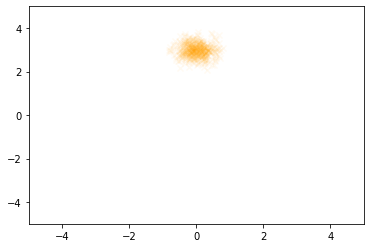

In [8]:
dataset_1 = CircleGaussiansDataset(n_gaussians=1, n_samples=500)
plt.scatter(dataset_1.X[:,0], dataset_1.X[:,1], alpha=.05, marker='x', c='orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow 

Epoch 0 -> loss: 6.34


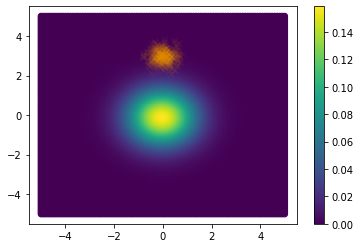

Epoch 250 -> loss: 2.46


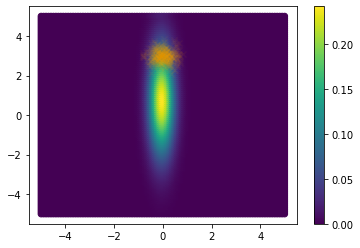

Epoch 500 -> loss: 2.04


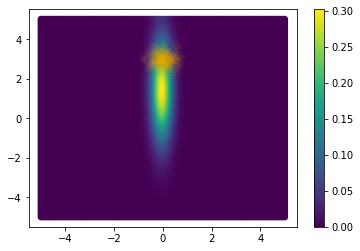

Epoch 750 -> loss: 1.18


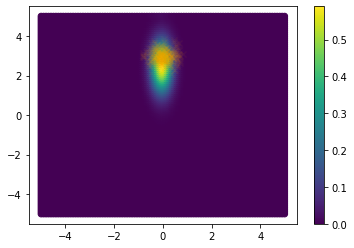

Epoch 1000 -> loss: 0.42


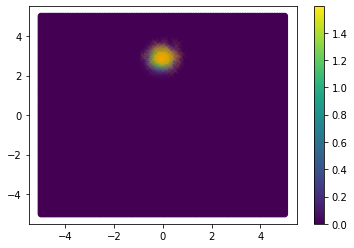

Epoch 1250 -> loss: 0.40


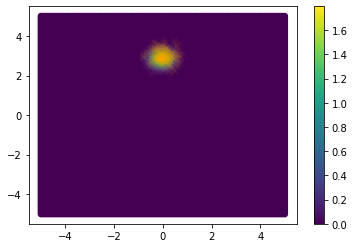

Epoch 1500 -> loss: 0.40


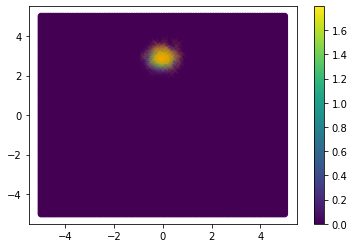

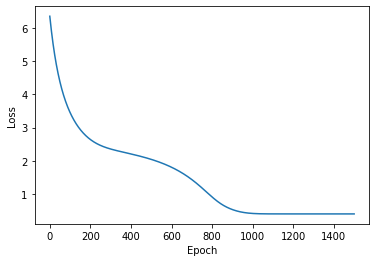

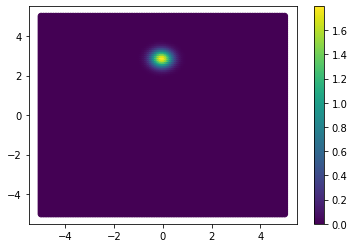

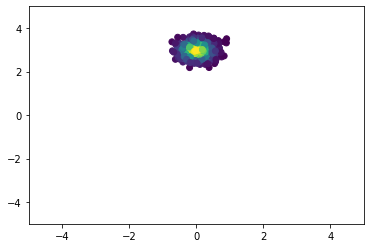

In [9]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_1, max_epochs=1500)

# Plots
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

### Radial flow (4 layers)

Epoch 0 -> loss: 7.95


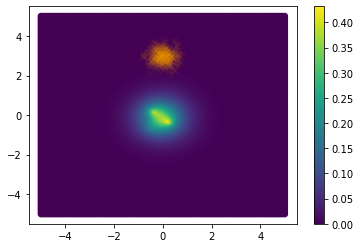

Epoch 250 -> loss: 3.26


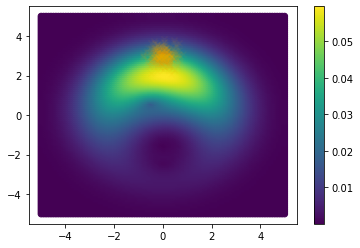

Epoch 500 -> loss: 2.73


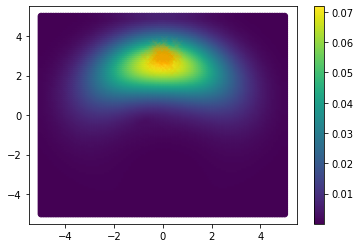

Epoch 750 -> loss: 2.54


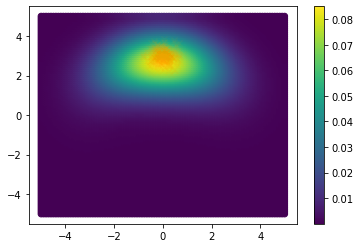

Epoch 1000 -> loss: 2.39


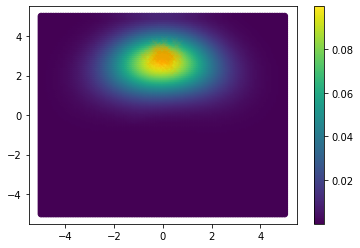

Epoch 1250 -> loss: 0.65


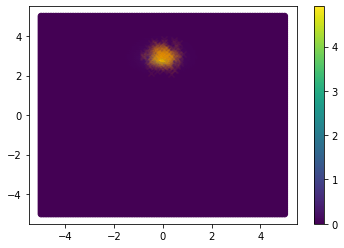

Epoch 1500 -> loss: 0.55


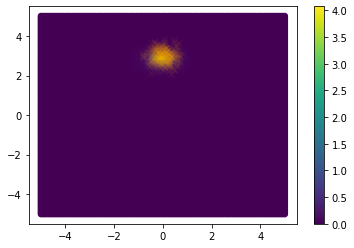

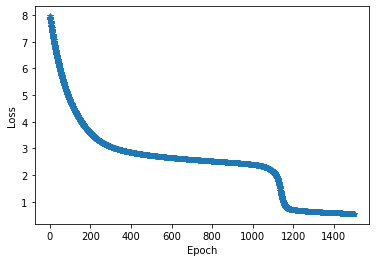

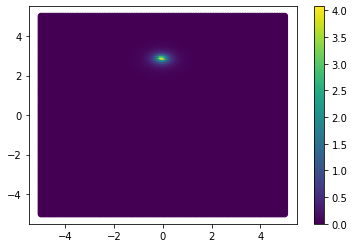

In [17]:
transforms = [InverseFlow(Radial()).to(device) for _ in range(4)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_1, max_epochs=1500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)

## Dataset 2: 3 Gaussians
The second dataset is composed of 3 gaussians with means on a circle.

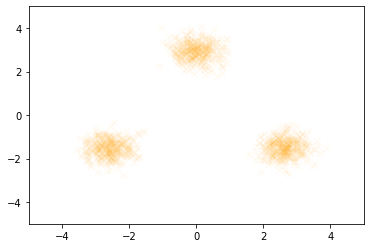

In [11]:
dataset_2 = CircleGaussiansDataset(n_gaussians=3, n_samples=400, variance=.4)
plt.scatter(dataset_2.X[:,0], dataset_2.X[:,1], alpha=.05, marker='x', c='orange')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()

### Affine flow

Epoch 0 -> loss: 6.45


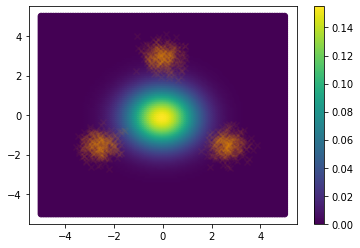

Epoch 250 -> loss: 4.37


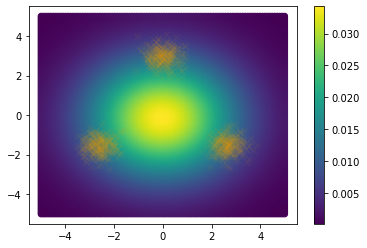

Epoch 500 -> loss: 4.37


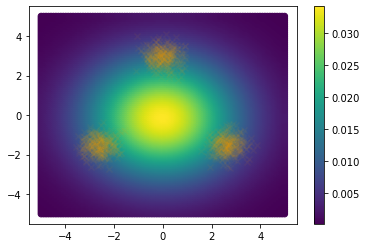

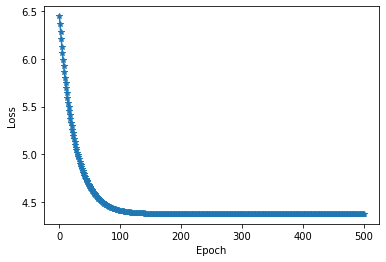

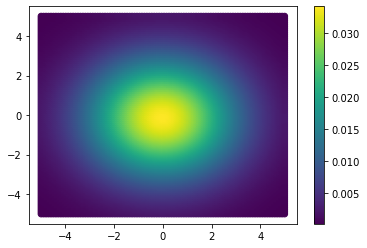

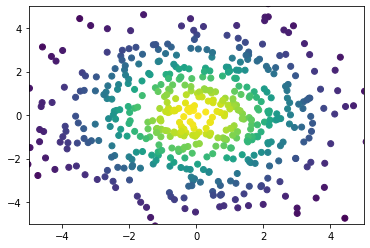

In [12]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_2, max_epochs=500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

Affine flow should fail here.

### Radial flow (32 layers)

Epoch 0 -> loss: 7.23


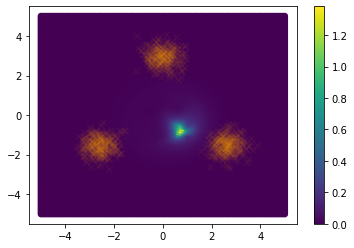

Epoch 100 -> loss: 2.86


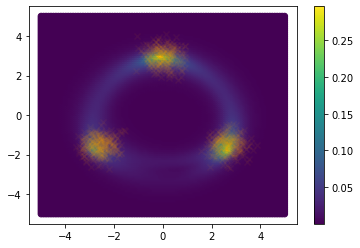

Epoch 200 -> loss: 2.50


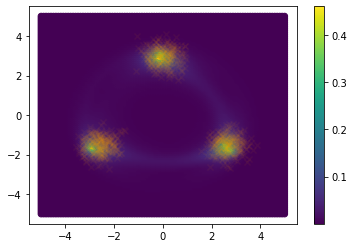

Epoch 300 -> loss: 2.37


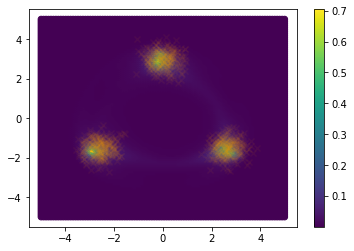

Epoch 400 -> loss: 2.32


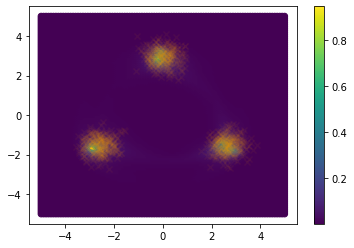

Epoch 500 -> loss: 2.29


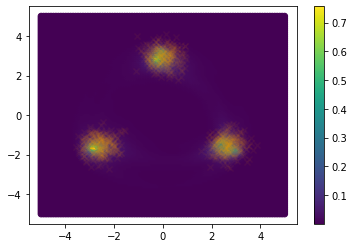

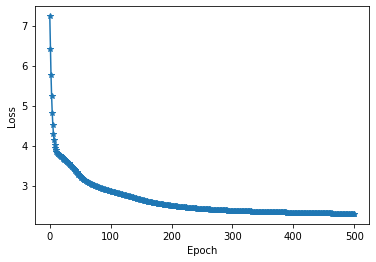

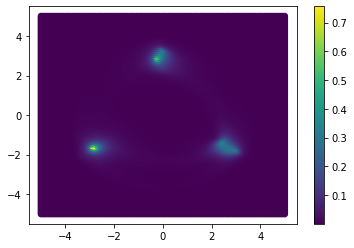

In [18]:
transforms = [InverseFlow(Radial()).to(device) for _ in range(32)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_2, max_epochs=500, frequency=100)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)

Using 32 layers of radial flow should lead to a good reasonable fit of the data after 500 epochs. Traning with more layers and for more epochs would improve the density estimation but would take more time. You might have to run the training multiple times to learn the three Gaussians (it learns sometimes only two Gaussians).

## Dataset 3: 2 Moons

The third dataset is composed of 2 moons. Affine flow should fail again. With more layers, Radial flow should work. 

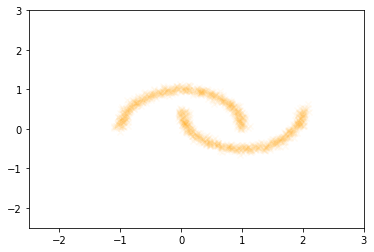

In [14]:
dataset_3 = MoonsDataset()
plt.scatter(dataset_3.X[:,0], dataset_3.X[:,1], alpha=.05, marker='x', c='orange')
plt.xlim(-2.5, 3)
plt.ylim(-2.5, 3)
plt.show()

### Affine flow 

Epoch 0 -> loss: 2.49


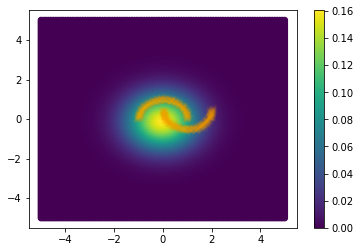

Epoch 250 -> loss: 2.00


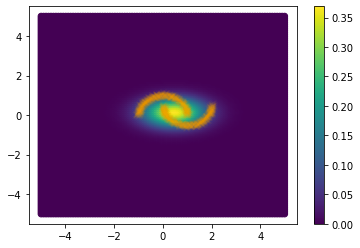

Epoch 500 -> loss: 2.00


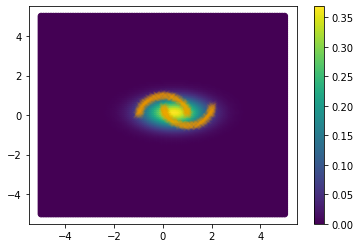

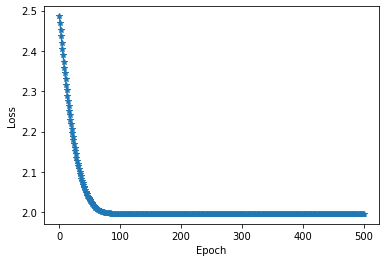

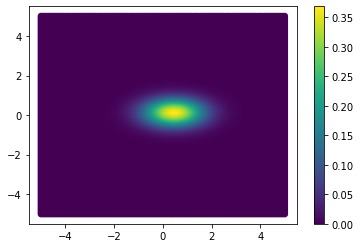

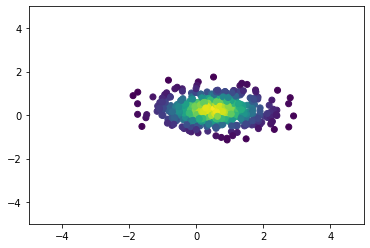

In [19]:
transforms = [Affine().to(device)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_3, max_epochs=500)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], device=device)
plot_samples(model)

Affine flow should fail here.

### Radial flow (32 layers)

Epoch 0 -> loss: 2.89


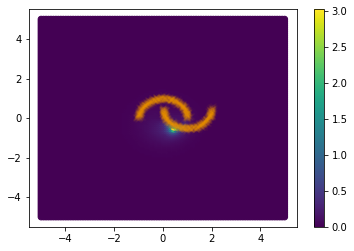

Epoch 100 -> loss: 1.57


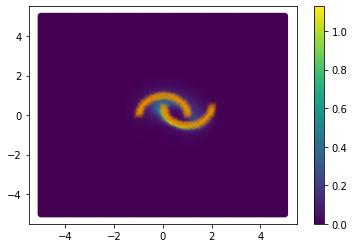

Epoch 200 -> loss: 1.20


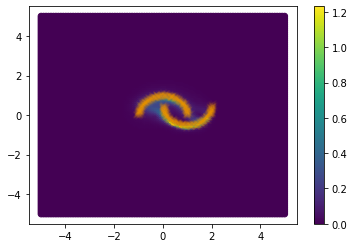

Epoch 300 -> loss: 0.97


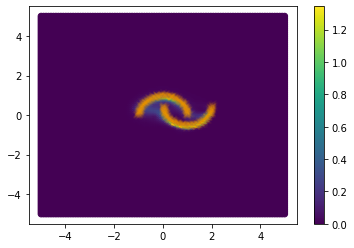

Epoch 400 -> loss: 0.86


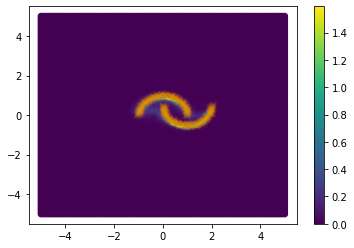

Epoch 500 -> loss: 0.78


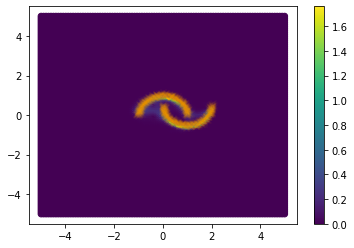

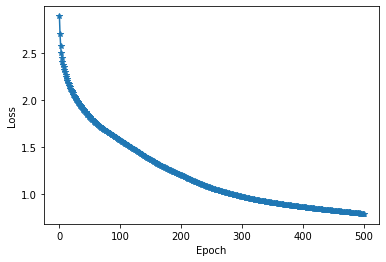

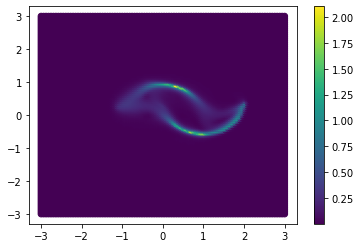

In [20]:
transforms = [InverseFlow(Radial()).to(device) for _ in range(32)]
model = StackedFlows(transforms, base_dist='Normal').to(device)
model, losses = train(model, dataset_3, max_epochs=500, frequency=100)

# Plots
plt.plot(losses, marker='*')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
plot_density(model, [], mesh_size=3, device=device)

Using 32 layers of radial flow should lead to a good reasonable fit of the data after 500 epochs. Traning with more layers and for more epochs would improve the density estimation but would take more time.